In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import torch
import os

In [2]:
EXPERIMENT_NAME = "rotated_mnist_test"
TASK_NAME = "rotated_mnist"

In [6]:
# EXPERIMENT_NAME = "celeba_test"
# TASK_NAME = "celeba"

## Process Experiment Results

Convert results from training and ablation from .pt files into .json files

In [3]:
results_path = f"results/{TASK_NAME}/{EXPERIMENT_NAME}_results.pt"
rand_results_path = f"results/{TASK_NAME}/{EXPERIMENT_NAME}_rand.pt"

In [4]:
def get_statistics_by_model(path):
    if not os.path.exists(path):
        print(f"Warning: {path} does not exist")
        return {}
    
    results = torch.load(path)
    metadata = results["metadata"]
    compiled_results = results["results"]

    param_factors = metadata["param_factors"]
    model_names = metadata["model_names"]
    num_runs = metadata["num_runs"]
    
    statistics_by_model = {}
    for model_name in model_names:
        mean_accuracies = []
        std_accuracies = []
        flops = []
        num_params = []
        for param_factor in param_factors:
            accuracies = []
            for run_num in range(num_runs):
                stats = compiled_results[model_name][param_factor][run_num]
                accuracies.append(stats["accuracy"])
                if run_num == 0:
                    flops.append(stats["flops"])
                    num_params.append(stats["num_params"])
            mean_accuracy = torch.Tensor(accuracies).mean().item()
            std_accuracy = torch.Tensor(accuracies).std().item()
            mean_accuracies.append(mean_accuracy)
            std_accuracies.append(std_accuracy)
        statistics_by_model[model_name] = {
            "mean_accuracies": mean_accuracies,
            "std_accuracies": std_accuracies,
            "flops": flops,
            "num_params": num_params,
        }
    return statistics_by_model

In [ ]:
statistics_by_model = {}
statistics_by_model.update(get_statistics_by_model(results_path))
# Uncomment after running ablation.py to get random model results
# statistics_by_model.update(get_statistics_by_model(rand_results_path))

In [10]:
# save results as json
json_path = f"results/{TASK_NAME}/{EXPERIMENT_NAME}_results.json"
with open(json_path, "w") as f:
    json.dump(statistics_by_model, f, indent=4)

## Graph Results

In [9]:
json_path = f"results/{TASK_NAME}/{EXPERIMENT_NAME}_results.json"
with open(json_path, "r") as f:
    statistics_by_model = json.load(f)

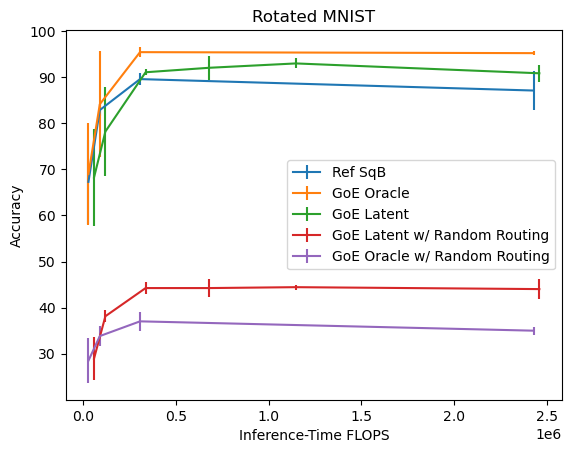

In [10]:
# Graph
model_name_to_lablel = {
    'ref_sqB': 'Ref SqB',
    'goe_oracle': 'GoE Oracle',
    'goe_random': 'GoE Random',
    'goe_latent': 'GoE Latent',
    'goe_latent_rand': 'GoE Latent w/ Random Routing',
    'goe_oracle_rand': 'GoE Oracle w/ Random Routing',
    
}

task_name_to_title = {
    'celeba': 'CelebA',
    'rotated_mnist': 'Rotated MNIST'
}

dont_plot = []
add_offset = ['goe_latent', 'goe_latent_rand']

for model_name, statistics in statistics_by_model.items():
    if model_name in dont_plot:
        continue
    mean_accuracies = statistics['mean_accuracies']
    std_accuracies = statistics['std_accuracies']
    flops = np.array(statistics['flops']) + (30000 if model_name in add_offset else 0)
    num_params = statistics['num_params']
    plt.errorbar(flops, mean_accuracies, yerr=std_accuracies, label=model_name_to_lablel[model_name])
plt.xlabel('Inference-Time FLOPS')
plt.ylabel('Accuracy')
plt.title(f'{task_name_to_title[TASK_NAME]}')
plt.legend()
plt.savefig(f'results/{TASK_NAME}/{EXPERIMENT_NAME}_plot.png')